# **Problem definition**

**Goal**:The objective of this project is to build a machine learning model that predicts whether a loan applicant is likely to default, enabling lenders to reduce financial risk and improve lending decisions. The target variable is loan_status (0 = fully paid, 1 = default).

**Features**: person_age,person_income,person_home_ownership,
       person_emp_length, loan_intent, loan_grade, loan_amnt,
       loan_int_rate, loan_percent_income,
       cb_person_default_on_file, cb_person_cred_hist_length,**loan_status**

In [15]:
!pip install xgboost shap

In [16]:
# CREDIT RISK PREDICTION WITH XGBOOST + SHAP
# Dataset: OpenML Credit Risk (ID: 43454)
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# **Data collection**

In [18]:
from sklearn.datasets import fetch_openml

# Fetch dataset from OpenML by ID (43454)
credit_data = fetch_openml(data_id=43454, as_frame=True)
df = credit_data.frame
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# **Data cleaning**

In [19]:
# Handling missing values
df.isna().sum()
#we have some missing values in person_emp_length and loan_int_rate

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


In [20]:
#median imputation is usually better for skewed features like employment length and loan_int_rate
for m in (["person_emp_length","loan_int_rate"]):
  df[m] = df[m].fillna(df[m].median())
df.isna().sum()
#missing values has been handled

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


In [21]:
#handling duplicate data
df.duplicated().any() #return True if dataset have atleast one duplicate row
df.drop_duplicates(inplace=True) #droping duplicate data and update in source dataset
df.duplicated().any()

np.False_

# **EDA(EXPLORATORY DATA ANALYSIS)**

In [22]:
df.shape # rows x columns

(32416, 12)

In [23]:
df.info() # To get overall info of features like datatype,features name,non-null count

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32416 non-null  int64  
 1   person_income               32416 non-null  int64  
 2   person_home_ownership       32416 non-null  object 
 3   person_emp_length           32416 non-null  float64
 4   loan_intent                 32416 non-null  object 
 5   loan_grade                  32416 non-null  object 
 6   loan_amnt                   32416 non-null  int64  
 7   loan_int_rate               32416 non-null  float64
 8   loan_status                 32416 non-null  int64  
 9   loan_percent_income         32416 non-null  float64
 10  cb_person_default_on_file   32416 non-null  object 
 11  cb_person_cred_hist_length  32416 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


In [24]:
# As we can see Values like age = 144 and employment length = 123 years are not realistic
# Almost certainly represent data errors,So we should cap those values
df["person_age"] = df["person_age"].clip(lower=18, upper=100)
df["person_emp_length"] = df["person_emp_length"].clip(lower=0, upper=60)

In [25]:
df.describe().T #quick statistical summary of numeric data by default.

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.741517,6.274489,20.00,23.00,26.00,30.00,100.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,32416.0,4.764993,4.007142,0.00,2.00,4.00,7.00,60.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,32416.0,11.014662,3.083050,5.42,8.49,10.99,13.11,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [26]:
df['loan_status'].value_counts() # Based on this, it is clear that the dataset is imbalanced.

,count
loan_status,
0,25327
1,7089


# **Feature Engineering**

In [27]:
# convert object data into numeric
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder() # using LabelEncoder to convert data type
    df[col] = le.fit_transform(df[col])

In [28]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,60.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4


# **Model building**

In [29]:
# Separate features & target
X = df.drop(columns=['loan_status'])
y = df['loan_status']
feature_names=X.columns
X=X.to_numpy()
y=y.to_numpy()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
model = xgb.XGBClassifier(n_estimators=600,learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,eval_metric="logloss")
model.fit(X_train, y_train) #train the model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

# **Model Evaluation**

In [31]:
# we use predict_proba for AUC, threshold tuning, risk scoring
#[:,1]-Since we are predicting loan default, we want probability of class 1
pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, pred_proba)
print("ROC–AUC:", auc)
print(classification_report(y_test, (pred_proba > 0.5).astype(int)))

ROC–AUC: 0.950078001451654
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6332
           1       0.97      0.74      0.84      1772

    accuracy                           0.94      8104
   macro avg       0.95      0.87      0.90      8104
weighted avg       0.94      0.94      0.93      8104



In [32]:
# SHAP value
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

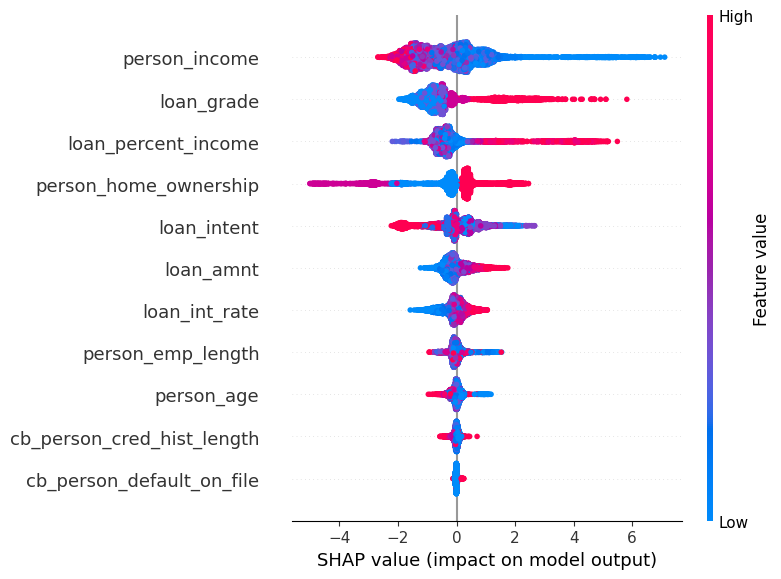

In [33]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test,feature_names=feature_names)

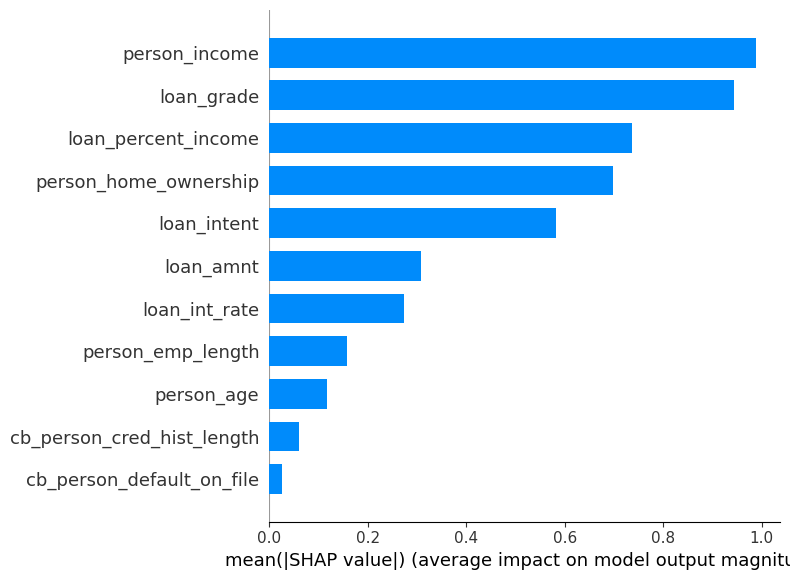

In [34]:
# SHAP Bar Plot
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=feature_names)

**Interpretation of Top 5 Global Features**

1. **person_income** - Annual income of the borrower
      - In the summary plot we can see that lower incomes (blue dot spread ont he right) tend to push SHAP values positive (increase default risk), while higher incomes(red dot ) push negative (reduce risk).
      - This suggests that applicants with limited(lower) income have a higher probability of missing repayments, while those with higher income levels are generally considered more creditworthy by the model.
  
2. **loan_grade** - Credit quality grade assigned by lenders to categorize borrowers based on factors such as credit history, credit score, and repayment patterns. The grades are assigned in alphabetical order (A, B, C, …) and are typically encoded as numeric values (0, 1, 2, …) for model processing.
      - Grade A (encoded as 0 -blue dot) indicates the highest credit quality and therefore the lowest predicted risk.
      - As the grade decreases (e.g., from B to C, D, and onward-red dot), the encoded value increases, which reflects lower credit quality and a higher predicted risk of default.
      - Thus, borrowers with lower loan grades (higher encoded values) tend to push SHAP values toward a higher default risk, while those with higher grades (lower encoded values) generally reduce the predicted default probability.

3. **loan_per_income** - Ratio of the loan amount to the borrower's income, reflecting the debt burden relative to income. In the SHAP summary plot, we can observe that:
      - Higher loan-to-income values (shown as red dots) tend to appear on the right side, contributing positive SHAP values, meaning they increase the predicted risk of default. This indicates that when the loan amount is large relative to income, the model sees a higher likelihood of repayment difficulty.
      - Lower loan-to-income values (shown as blue dots) cluster on the left side, contributing negative SHAP values, meaning they reduce the predicted default risk. This suggests that when borrowers have a loan amount small relative to their income, the model considers them more capable of repayment.

4. **person_home_ownership** -Person Home Ownership (Encoded: rent=3, own=2, other=1, mortgage=0)
      - Higher encoded values (mainly Rent, shown as red dots) appear predominantly on the right side of the plot with positive SHAP values, meaning they increase the predicted risk of credit default.Borrowers who rent their home typically have more financial obligations because they must pay both rent and loan installments. They do not have property ownership that can provide financial security.
      - Lower encoded values (such as Mortgage, Other, and fully Own, shown as blue and purple dots) appear on the left side of the plot with negative SHAP values, indicating they reduce the predicted default risk.Borrowers who own their home (fully or partially through a mortgage) often show greater financial stability.
5. **loan_intent**- (loan intention) Purpose of the loan(Encoded: personal=4, education=1, medical=3, venture=5, homeimprovement=2, debtconsolidation=0)
      - Higher encoded values (especially Venture, represented by red dots) appear primarily on the left side of the plot with negative SHAP values, meaning they reduce the predicted credit risk.
      - Borrowers taking venture/business loans may be using the funds to start or grow a business, which can potentially generate future income. This may improve their ability to repay debts. The model therefore learns that, historically, these applicants may be less likely to default, pushing SHAP values negative.
      - Lower encoded values (Debt Consolidation, shown as blue/purple dots) appear on the right side of the plot with positive SHAP values, meaning they increase the predicted default risk.
      - For example: Borrowers taking debt consolidation loans are combining multiple existing debts into a new loan. This can be a sign of financial stress, existing high debt burden, or prior repayment challenges. As a result, these values push SHAP values positive, increasing default risk.

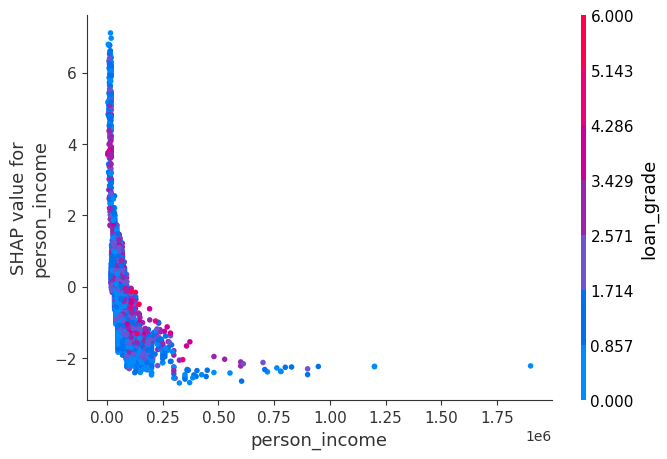

In [35]:
# SHAP Dependence Plot (It is meant for global feature behavior, not an individual.)
top_feature = feature_names[np.argsort(np.abs(shap_values).mean(axis=0))[-1]]
shap.dependence_plot(top_feature, shap_values, X_test,feature_names=feature_names)

**Interpretation Using dependence plot**

- On the left side of the plot, where income is low, SHAP values are mostly positive, indicating a higher predicted risk of default.
- As income increases (towards the right) we can see high density of blue dot in  SHAP values move toward negative values, showing that higher income and high grade (like A=0,B=1..) reduces the likelihood of default.
- The red/pink points (higher encoded values) tend to appear more in areas with positive SHAP values, indicating higher default risk. These correspond to lower loan grades (e.g., E=4, F=5, G=6).
- The dependence plot shows that lower income combined with a lower loan grade (higher encoded grade value) contributes most strongly to an increase in default risk. In contrast, higher income together with a higher loan grade(A,B) pushes SHAP values negative, reducing the predicted risk. This indicates that the model associates financial capacity (income) and credit quality (loan grade) in its risk assessment.

In [36]:
#plot force plot for each applicant
def force_plot(i):
    print("\nApplicant ID:", i)
    print("Predicted default probability:",pred_proba[i])
    shap.force_plot(explainer.expected_value,shap_values[i],X_test[i],feature_names=feature_names,matplotlib=True)
    explanation_for_sample = shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=X_test[i],
    feature_names=feature_names)
    shap.plots.waterfall(explanation_for_sample, max_display=6)

In [37]:
# Select three applicants: high risk, low risk, borderline
high = pred_proba.argmax()
low = pred_proba.argmin()
mid =(np.abs(pred_proba - 0.5)).argmin()
# for explaining each applicant i use force plot and for clear visibility of feature i use waterfall plot


Applicant ID: 5048
Predicted default probability: 0.9999974


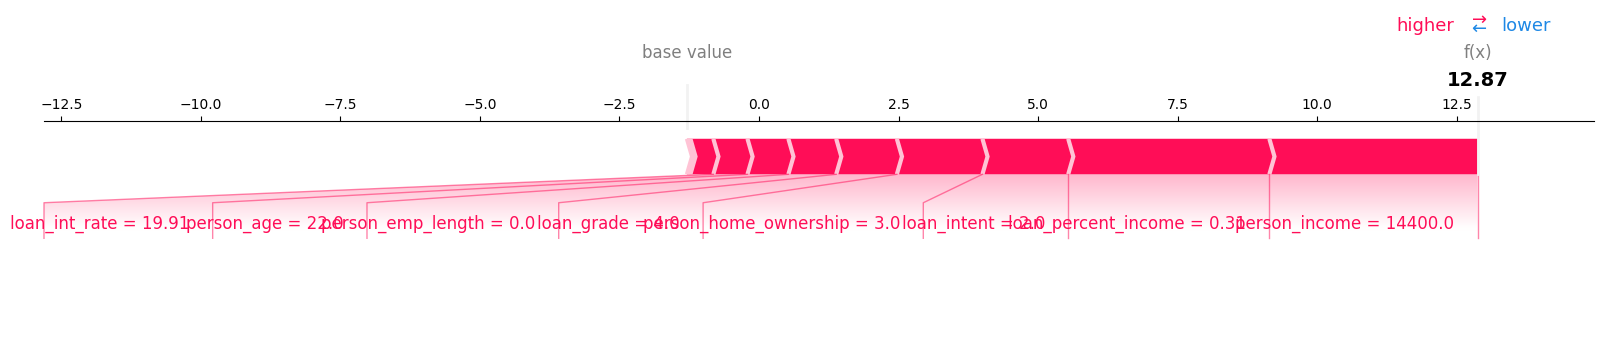

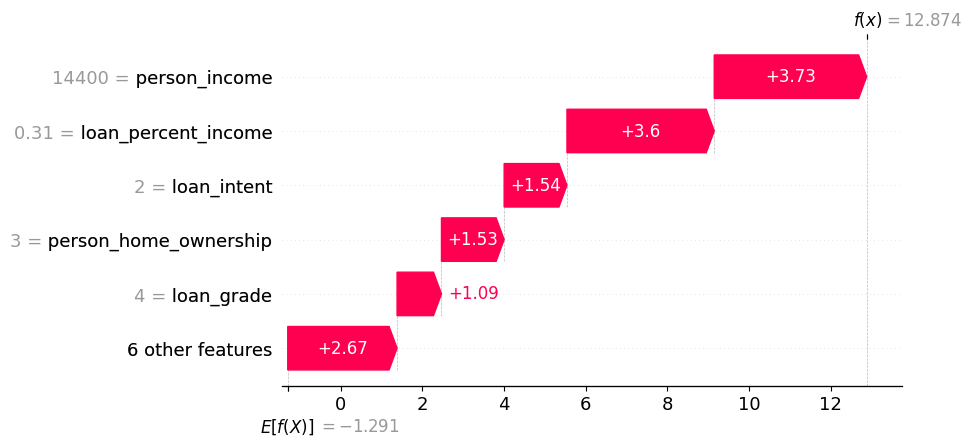

In [38]:
# force plot for high risk applicant
force_plot(high)

**Interpretation of Applicant 1: High-Risk Borrower**
- The model produces a final prediction score of f(x) = 12.874, indicating a high likelihood of credit default for this applicant. The SHAP force plot shows that several features push the prediction strongly toward higher risk, outweighing the baseline model expectation.The key factor(Features) responsible for this prediction:
1. **person_income** = 14,400 &rarr; +3.73(shap value)- The applicant's annual income is relatively low, which significantly increases the predicted probability of default. Limited income may reduce the borrower's capacity to meet loan repayment.
2. loan_percent_income = 0.31 &rarr; +3.6-
About 31% of the applicant's income is required to repay the loan, indicating a high repayment burden.Higher debt-to-income ratio is strongly correlated with repayment difficulties resulting in Higher risk.
3. loan_intent = 2 (Home Improvement or similar) &rarr; +1.54-
The purpose of the loan contributes moderately to increased risk. The model has learned that borrowers seeking this category of loan may have less financially critical needs, or the investment may not directly improve repayment capacity.
4. person_home_ownership = 3 (likely Rent) &rarr; +1.53 -
The applicant's home ownership status (rent) indicates higher financial vulnerability, as the applicant has continuing housing costs and no property asset to secure financial stability. This pushes the prediction further toward default.
5. loan_grade = 4 (lower credit grade) &rarr; +1.09-
A weaker loan grade indicates that the applicant is less creditworthy borrower, which historically correlates with higher default rates, thereby increasing the risk.
6. Other contributing features &rarr; +2.67 -
Additional smaller factors collectively add risk, contributing the model's final assessment.


Applicant ID: 3733
Predicted default probability: 2.2106224e-05


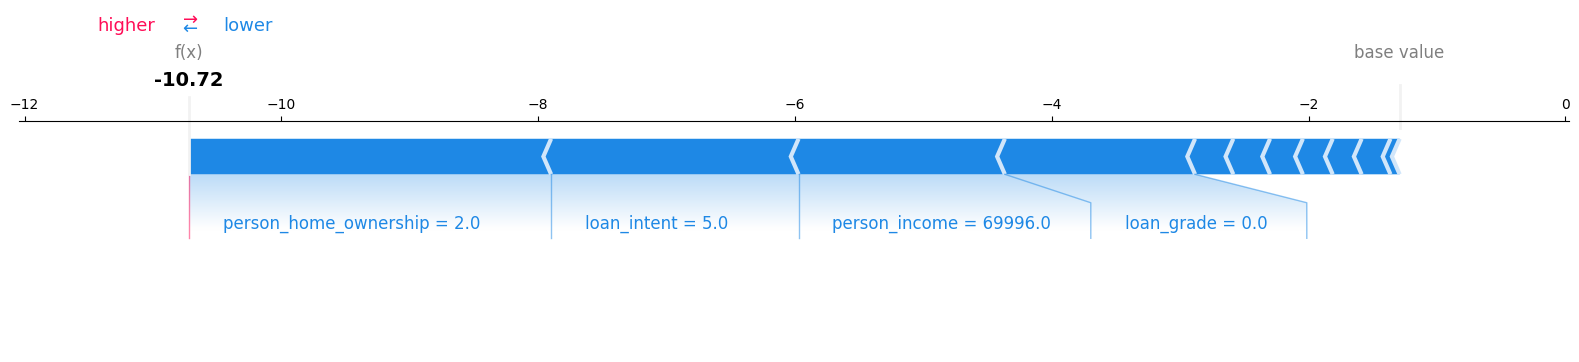

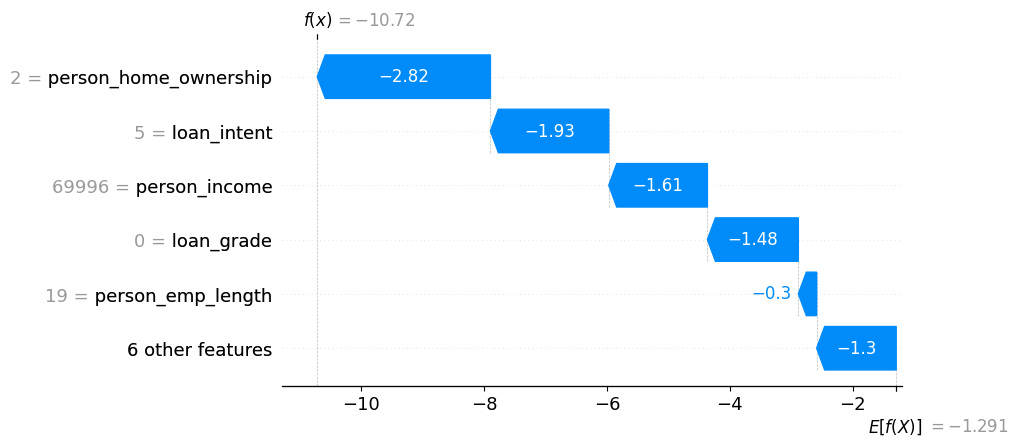

In [39]:
# force plot for low risk applicant
force_plot(low)

**Interpretation of Applicant 2: low-Risk Borrower**
- The model produces a final prediction score of f(x) = -10.72, which is far below the baseline value. This indicates that the model predicts a very low likelihood of credit default for this applicant. Multiple features strongly contribute to reducing the risk score,They are:
1. person_home_ownership =2 &rarr; -2.82  -
The applicant's home ownership status (Own or other secured housing) significantly lowers the risk of default. Property ownership typically provides greater financial stability and reduces housing cost uncertainty, increasing repayment reliability.
2. loan_intent =5 &rarr; -1.93 -
The loan purpose (likely Venture or any purpose with healthy repayment outcomes) decreases risk. This suggests that applicants using funds for business or productive purposes may have higher capacity to generate income for loan repayment.
3. person_income =69,996 &rarr; -1.61 -
A relatively high annual income substantially improves the applicant's repayment . Higher income = reduces the probability of payment default.
4. loan_grade =0 ( A grade) &rarr; -1.48  -
The applicant has a top-tier loan grade, indicating strong creditworthy profile. The model associates this with a significantly lower default risk.
5. person_emp_length = 19 (years) &rarr; 0.30 -
Long-term employment indicates job stability and consistent income, which contributes to lowering the probability of payment default.
6. Other contributing features &rarr; 1.30 -
Additional factors collectively strengthen the low-risk assessment


Applicant ID: 2411
Predicted default probability: 0.4999411


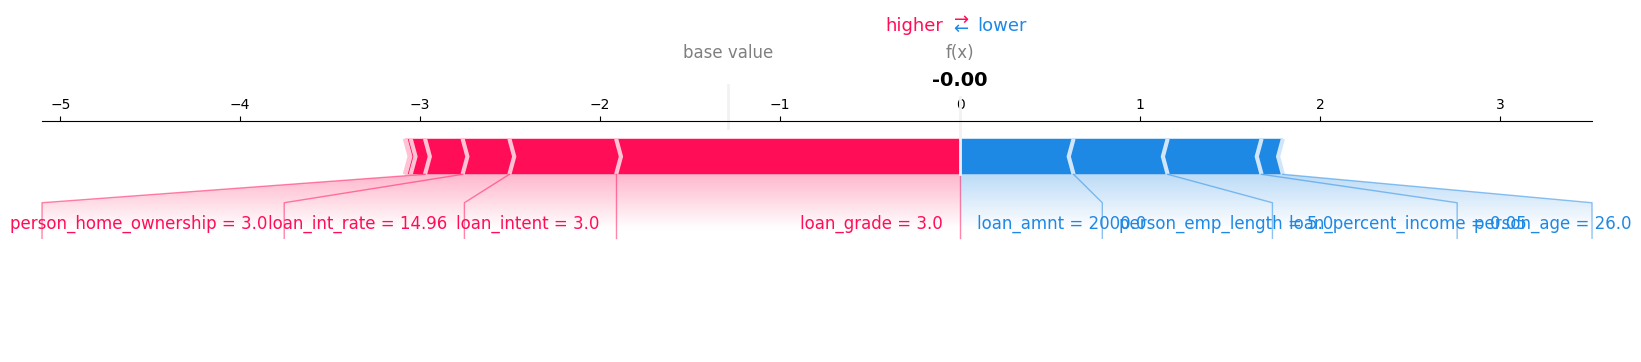

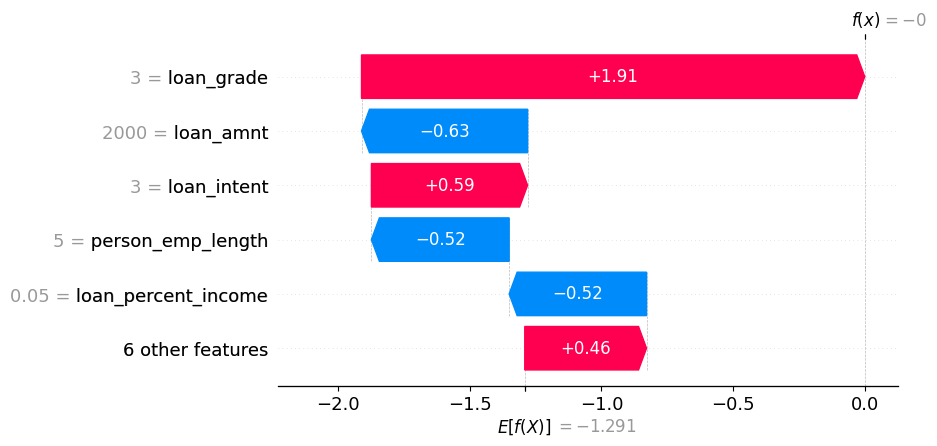

In [40]:
#force plot for baseline risk applicant
force_plot(mid)

**Interpretation of Applicant 3 Borderline - Risk Borrower**
- The model produces a prediction of f(x) ~ 0.00, which converts to a default probability of approximately 0.4999 (~ 49.99%). This value is almost exactly in the middle of the probability range, indicating a borderline credit risk. The model finds nearly equal forces(features) pushing the prediction toward higher and lower risk.
- Risk-Increasing Features ( positive SHAP Values)
    1. loan_grade=3 &rarr; +1.91 -
A higher grade value 3 = D grade indicates weaker credit quality. Lower-grade borrowers  shows higher default likelihood, so this strongly increases the predicted risk.
    2. loan_intent = 3(Medical) &rarr; 0.59- The purpose of the loan (Medical) is associated with moderately higher repayment challenges, increasing risk slightly.
    3. 6 other features &rarr; +0.46 - Additional smaller factors collectively contribute a minor increase in default risk.
- Risk-Reducing Features (negative SHAP Values)
    1. loan_amnt = 2,000 &rarr; -0.63 - A relatively small loan amount reduces risk because the repayment burden might be easier.
    2. person_emp_length = 5 (years) &rarr; -0.52 - Stable employment history indicates job stability and consistent income contributing to reduces risk.
    3. loan_percent_income = 0.05 &rarr; -0.52 -
debt-to-income ratio 0.05 indicates ,only 5% of the applicant's income is needed to repay the loan, indicating a very manageable repayment burden, which significantly lowers risk.

- This applicant represents a borderline case where the model expresses significant uncertainty. The decision outcome may change if the lending institution applies a more conservative risk threshold, highlighting the importance of aligning ML model outputs with business risk policies.

**Regulatory Compliance and SHAP Transparency Summary**

Credit risk models must comply with strict regulatory requirements concerning fairness, explainability, and non-discrimination. Financial regulators require that institutions are able to justify automated credit decisions, particularly when applicants are denied credit.

While gradient-boosted algorithms (XGBoost) are highly predictive, they can behave as black-box models, making it difficult to articulate why a decision was made.But SHAP addresses this challenge by providing mathematically consistent, feature-level contribution scores for both global and individual predictions.Using SHAP supports regulatory compliance by enabling:

- Global Model Transparency
    - Identification of the key drivers of credit risk and documentation of how the model uses financial attributes such as income, loan-to-income ratio, loan grade, and employment history.

- Individual Adverse Action Explanations
    - Clear communication to denied applicants regarding which factors most influenced their decision, supporting requirements for adverse action notices.

- Bias and Fairness Auditing
    - Detection of potential proxy discrimination by analyzing SHAP value distributions across groups (like age, gender, region), improving fairness assessments.

- Model Governance and Ongoing Monitoring
    - SHAP enables repeatable, auditable explanations, supporting model validation, challenger model comparison, drift monitoring, and regulatory review.

As a result, SHAP enhances the responsible deployment of machine learning-based credit scoring systems, ensuring they meet both predictive performance and ethical, legally compliant decision-making standards.
